In [7]:
# import modules
import joblib
import pandas as pd
import numpy as np
import pytz
from  datetime import datetime, timedelta
import yfinance as yf

import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.metrics import r2_score

from statsmodels.tsa.seasonal import seasonal_decompose

from tensorflow import keras
from tensorflow.keras.layers import  Conv1D, MaxPooling1D, LSTM, Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from keras.models import load_model

from utils import load_file, localize_tz, additive_decom, calculate_technical_indicators,split_data ## this is custom function make for this model

from scikeras.wrappers import KerasRegressor

# Train the model

Epoch 1/13
212/212 [==============================] - 8s 19ms/step - loss: 0.0045
Epoch 2/13
212/212 [==============================] - 4s 18ms/step - loss: 7.7642e-04
Epoch 3/13
212/212 [==============================] - 3s 16ms/step - loss: 6.9443e-04
Epoch 4/13
212/212 [==============================] - 4s 19ms/step - loss: 5.9046e-04
Epoch 5/13
212/212 [==============================] - 4s 18ms/step - loss: 6.1344e-04
Epoch 6/13
212/212 [==============================] - 3s 16ms/step - loss: 6.3257e-04
Epoch 7/13
212/212 [==============================] - 4s 19ms/step - loss: 5.7544e-04
Epoch 8/13
212/212 [==============================] - 4s 18ms/step - loss: 5.5822e-04
Epoch 9/13
212/212 [==============================] - 4s 18ms/step - loss: 5.4559e-04
Epoch 10/13
212/212 [==============================] - 4s 17ms/step - loss: 4.8704e-04
Epoch 11/13
212/212 [==============================] - 4s 17ms/step - loss: 5.0115e-04
Epoch 12/13
212/212 [==============================] - 4

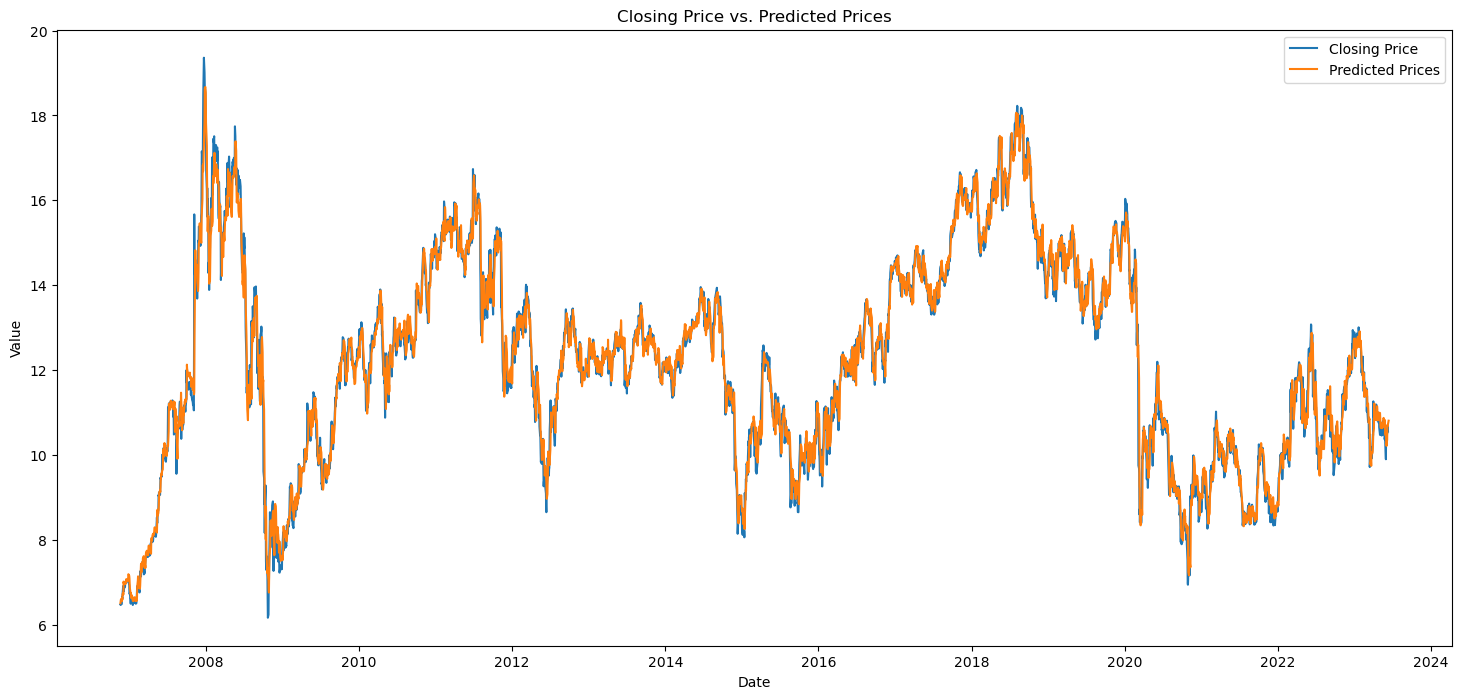

RMSE for test data is: 0.40000297065174567
r2 for test data is : 0.9733169266836741
predicted price for tomorrow based on todays date of 2023-06-12 00:00:00+01:00 is [[10.805031]]


In [8]:
# Train the model ## before training go down to download the updated data for model training
df = load_file("GALP.LS_daily_data.xlsx")  # you can put your desired stock data to train model. Before using this model
                                            #dont forget to fine tune the model for better result. The file for model building and finetuning is in main_mvp.ipynb file. 
df = localize_tz(df)
df = additive_decom(df)
df = calculate_technical_indicators(df)
X, y = split_data(df)


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Save the X_scaler for prediction  data
scaler_filename = "X_scaler.save"
joblib.dump(scaler, scaler_filename)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
# Save the y_scaler for prediction data
scaler_filename = "y_scaler.save"
joblib.dump(scaler, scaler_filename)

# sequence of window for input
window_size = 20
# Create input sequences and corresponding labels
X_sequence, y_sequence = [], []

for i in range(window_size, len(X_scaled)):
    X_sequence.append(X_scaled[i-window_size:i])
    y_sequence.append(y_scaled[i])  

# Convert the data to numpy arrays
X_sequence, y_sequence = np.array(X_sequence), np.array(y_sequence)


# Reshape the data for input to the CNN-LSTM model
X_sequence = X_sequence.reshape((X_sequence.shape[0], X_sequence.shape[1], X_sequence.shape[2]))

# Build the model (best paremeter: filter_size': 64, 'kernel_size': 3, 'pool_size': 2, 'unit': 150, 'epoch': 10, 'batch_size': 20)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_sequence.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(125, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# Train the model
model.fit(X_sequence, y_sequence, epochs=13, batch_size=20)


# Evaluate the model on the test set
predicted_prices = model.predict(X_sequence)
# Inverse transform the predicted prices
predicted_prices = pd.DataFrame(scaler.inverse_transform(predicted_prices))

# Inverse transform the actual prices
actual_prices = pd.DataFrame(scaler.inverse_transform(y_sequence.reshape(-1, 1)))

# Claculate MSE
error = np.sqrt(mean_squared_error(actual_prices,predicted_prices))
r2 = r2_score(actual_prices.values, predicted_prices.values)


# Plot the desired output and predicted prices against the dates
plt.plot(X[window_size:-1].index, y[window_size:-1], label='Closing Price')
plt.plot(X.index[window_size:], predicted_prices.values, label='Predicted Prices')

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Closing Price vs. Predicted Prices')
plt.show()
print(f"RMSE for test data is: {error}")
print(f"r2 for test data is : {r2}")
print(f"predicted price for tomorrow based on todays date of {y[20:].index[-1]} is {predicted_prices.values[-1:]}")





In [9]:
## Save the trained model
model.save('galp_final.h5')


In [5]:
#end_time, and period (how many years, or days worth data you want, if you want to get all the data set period as max)

interval = '1d'
#end_date = datetime.now().strftime('%Y-%m-%d')

# Retrieve data for each symbol
data = yf.download("GALP.LS", period = "max",  interval= interval)

# Convert datetime values to timezone-naive
#Sdata.index = data.index  #.tz_localize(None)

# Create a dataframe for the stock data
df = pd.DataFrame(data)

filename = "GALP.LS_daily_data.xlsx"
df.to_excel(f"{filename}", index=True)


[*********************100%***********************]  1 of 1 completed


In [11]:
#This code is for prediction data download with period of 4 years 
interval = '1d'
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=1460)).strftime('%Y-%m-%d')
# Retrieve data for each symbol
data = yf.download("GALP.LS", start= start_date,  end = end_date, interval= interval)

# Convert datetime values to timezone-naive
data.index = data.index#.tz_localize(None)

# Create a dataframe for the stock data
df = pd.DataFrame(data)

filename = "./flask/uploads/GALP.LS_daily_data.xlsx"
df.to_excel(f"{filename}", index=True)

[*********************100%***********************]  1 of 1 completed
